Примеры:
* https://github.com/bigartm/bigartm-book/blob/master/ARTM_example_RU.ipynb
* https://github.com/bigartm/bigartm-book/blob/master/ARTM_tutorial_RU.ipynb
* http://localhost:8888/notebooks/examples/2/%D0%94%D0%B5%D0%BC%D0%BE%D0%BD%D1%81%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F-BigARTM-0.8.0.ipynb

In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

# Адрес, по которому находятся данные
BATCH_ADRESS = 'batches_news'

# Вывод версии BigARTM
print(artm.version())

0.10.0


In [2]:
# Установка адреса, по которому находятся данные
batch_vectorizer = artm.BatchVectorizer(
    data_path=BATCH_ADRESS, data_format='batches'
)

In [3]:
# Пересоздание словаря для модели и сохранение его в файл

# Устанавливается название словаря для модели
dictionary_address = BATCH_ADRESS + '/dictionary.dict'

# Инициализация словоря для модели
dictionary = artm.Dictionary()

# Удаление словаря, оставшегося после предыдущих запусков
if os.path.isfile(dictionary_address):
    os.remove(dictionary_address)
    
# Сохранение словаря в файл
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary.save(dictionary_path=dictionary_address)

# Загрузка словаря из файла
dictionary.load(dictionary_path=dictionary_address)
print("Количество слов в словаре:", dictionary.__dict__['_master'].get_info().dictionary[0].num_entries)


# Фильтрация

# Убираются слова, которые попадаются меньше чем в n процентов документов
dictionary.filter(min_df_rate=0.01)
print(
    "Количество слов в словаре после фильтрации по min_df_rate:", 
    dictionary.__dict__['_master'].get_info().dictionary[0].num_entries
)

# Убираются слова, которые попадаются больше чем в n процентов документов
dictionary.filter(max_df_rate=0.5)
print(
    "Количество слов в словаре после фильтрации по max_df_rate:", 
    dictionary.__dict__['_master'].get_info().dictionary[0].num_entries
)

# Убираются редкие слова по всей коллекции
# Слово встречается во всей коллекции больше чем n раз
dictionary.filter(min_tf=10)
print(
    "Количество слов в словаре после фильтрации по min_tf:", 
    dictionary.__dict__['_master'].get_info().dictionary[0].num_entries
)

# Убираются частые слова по всей коллекции
# Слово встречается во всей коллекции меньше чем n раз
dictionary.filter(max_tf=2000)
print(
    "Количество слов в словаре после фильтрации по max_tf:", 
    dictionary.__dict__['_master'].get_info().dictionary[0].num_entries
)

Количество слов в словаре: 75725
75180
19310
1819


In [4]:
def new_default_model(topic_count, dictionary):
    
    # Создание модели
    model_artm = artm.ARTM(
        topic_names=['topic_{}'.format(i) for i in range(topic_count)], 
        cache_theta=True,
        #class_ids={'text': 1.0},
    )

    # Инициализация модели
    model_artm.initialize(dictionary=dictionary)
    model_artm.num_document_passes = 1

    # Установка отслеживаемых параметров
    # Перплексия (чем она меньше тем лучше)
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
    # Разреженность матрицы Phi (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    # Разреженность матрицы Theta (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    # Анализ самых используемых слов по темам
    model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))
    # Анализ ядра тем на контраст и чистоту
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
    #model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))
    
    return model_artm

In [5]:
def model_print_results(model_artm):
    
    # Графики
    
    fig = plt.figure(figsize=(15, 15))

    ax = fig.add_subplot(321) 
    ax.plot(model_artm.score_tracker["PerplexityScore"].value)
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('PerplexityScore')
    ax.grid(True)
    
    ax = fig.add_subplot(323)  
    ax.plot(model_artm.score_tracker["SparsityPhiScore"].value)
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityPhiScore')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = fig.add_subplot(324)  
    ax.plot(model_artm.score_tracker["SparsityThetaScore"].value)
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityThetaScore')
    ax.grid(True)
    ax.set_ylim([0,1])
    
    ax = fig.add_subplot(325)  
    ax.plot(model_artm.score_tracker["TopicKernelScore"].average_contrast)
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_contrast')
    ax.grid(True)
    ax.set_ylim([0,1])
    
    ax = fig.add_subplot(326)  
    ax.plot(model_artm.score_tracker['TopicKernelScore'].average_purity)
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_purity')
    ax.grid(True)
    ax.set_ylim([0,1])
    
    plt.show()
    
    
    # Конечные значения
    
    print("PerplexityScore:", model_artm.score_tracker["PerplexityScore"].last_value)
    print("SparsityPhiScore:", model_artm.score_tracker["SparsityPhiScore"].last_value)
    print("SparsityThetaScore:", model_artm.score_tracker["SparsityThetaScore"].last_value)
    print()
    print("TopicKernelScore_average_contrast:", model_artm.score_tracker["TopicKernelScore"].last_average_contrast)
    print("TopicKernelScore_average_purity:", model_artm.score_tracker['TopicKernelScore'].last_average_purity)
    
    print()
    
    
    # Главные слова в темах
    
    print("TopTokensScore:")
    topic_list = list(model_artm.score_tracker['TopTokensScore'].last_tokens.keys())
    for topic_name in topic_list:
        print(topic_name + ': ', end='')
        print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

In [9]:
params = {
    'topic_count': 15,
    'num_collection_passes': 10,
    'SparsePhi': {
        'name': 'SparsePhi',
        'tau': -5
    },
    'SparseTheta': {
        'name': 'SparseTheta',
        'tau': -2
    },
}

In [10]:
# Базовая пустая модель
model_artm = new_default_model(params['topic_count'], dictionary)
model_artm.save("news_model_0")

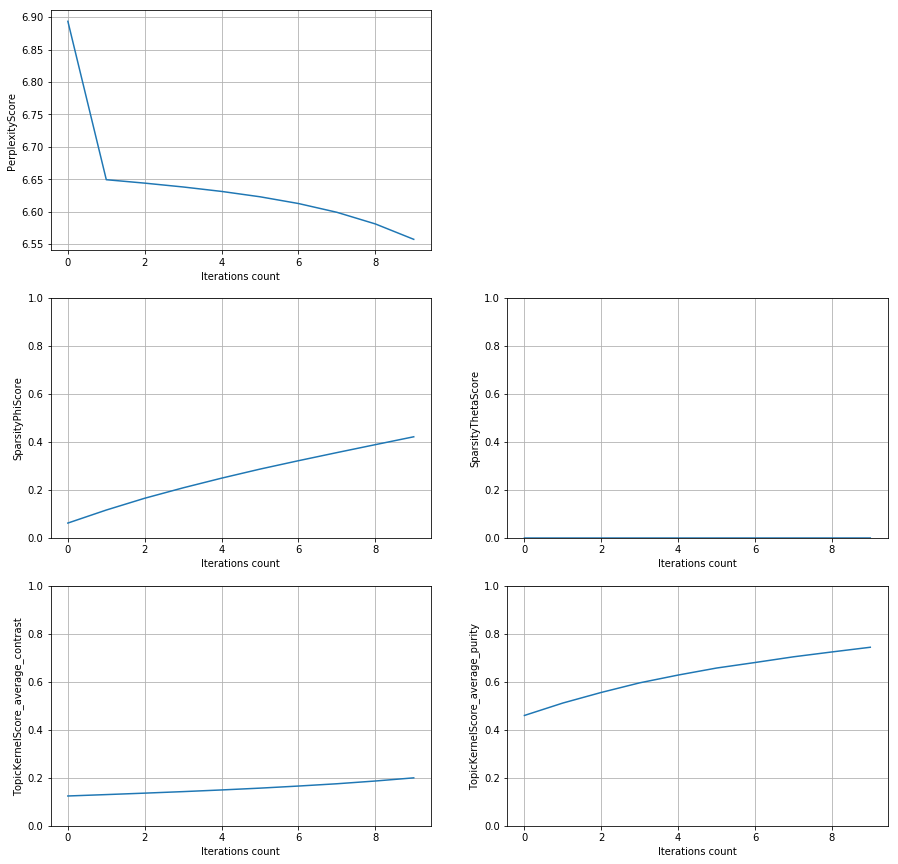

PerplexityScore: 6.5574164390563965
SparsityPhiScore: 0.4221000671386719
SparsityThetaScore: 0.00010759081487776712

TopicKernelScore_average_contrast: 0.1999346762895584
TopicKernelScore_average_purity: 0.7444775104522705

TopTokensScore:
topic_0: ['наручник', 'станция', 'правый', 'помнить', 'шизо', 'специальный', 'возраст', 'предприятие', 'иванов', 'особо']
topic_1: ['волков', 'пикет', 'волк', 'особо', 'сторонник', 'публичный', 'вконтакте', 'обязывать', 'леонид', 'собрание']
topic_2: ['тяжкий', 'повлечь', 'травма', 'преступный', 'кража', 'эпизод', 'зона', 'следовать', 'детский', 'руслан']
topic_3: ['банк', 'зарплата', 'офис', 'строительство', 'завод', 'выделять', 'похищение', 'мошенничество', 'совершенный', 'похищать']
topic_4: ['студент', 'скорый', 'вещество', 'скончаться', 'увидеть', 'помнить', 'рядом', 'илья', 'предмет', 'возле']
topic_5: ['подросток', 'пожар', 'травма', 'проводиться', 'покушение', 'повреждение', 'кадыров', 'служебный', 'мальчик', 'причинение']
topic_6: ['участок'

In [11]:
# Модель 1_1
# Запуск регуляризатора SparsePhi

model_artm = new_default_model(params['topic_count'], dictionary)
model_artm.load("news_model_0")

if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])
model_print_results(model_artm)

model_artm.save("news_model_1_1")

In [ ]:
# Модель 1_2
# Запуск регуляризатора SparseTheta к уже включенному SparsePhi

model_artm = new_default_model(params['topic_count'], dictionary)
model_artm.load("news_model_1_1")

if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']
    
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])
model_print_results(model_artm)

model_artm.save("news_model_1_2")

In [ ]:
# Модель 2_1
# Запуск регуляризаторов SparsePhi и SparseTheta одновременно и сначала обучения

model_artm = new_default_model(params['topic_count'], dictionary)
model_artm.load("news_model_0")

if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']
    
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])
model_print_results(model_artm)

model_artm.save("news_model_2_1")

In [131]:
# Установка регуляризаторов
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi'))
#model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta'))
#model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi'))


#model_artm.regularizers.add(artm.TopicSelectionThetaRegularizer(name='TopicSelectionTheta', tau=0.1))

In [132]:
# Правка регуляризаторов
model_artm.regularizers['SparsePhi'].tau = -3
#model_artm.regularizers['SparseTheta'].tau = -2
#model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

(0, 87.09707260131836)

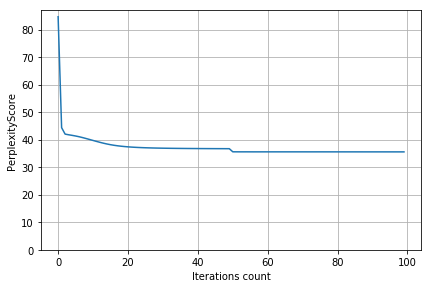

In [131]:
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(321) 
ax.plot(model_artm.score_tracker["PerplexityScore"].value)
ax.set_xlabel('Iterations count')
ax.set_ylabel('PerplexityScore')
ax.grid(True)
ax.set_ylim(0, ax.get_ylim()[1])

Полезные идеи по нулевым значениям:
https://github.com/bigartm/bigartm/issues/664